# Implemented ItemBased approach using SVD
### Paper: http://www.tmrfindia.org/ijcsa/v3i34.pdf

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt

# clusterization and dim. reduction
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Neighbor
from scipy.spatial.distance import pdist,squareform

RANDOM_STATE = 17

In [3]:
data = 0  # data for recommedation purposes

## Get user-item matrix R

In [5]:
UI = data.tocsr()

In [6]:
# create a mini-batch for experiments (less computational time)
batch = UI.toarray()[:1000]

### Preprocess R for imputing missing values

In [7]:
# compute the average of all rows and cols
mean_rows = batch.mean(axis=1)
mean_cols = batch.mean(axis=0)

In [8]:
## replace missing values with the average of cols subtracted with the average of rows
bat = np.copy(batch)
np.place(bat, bat == 0, mean_cols)
bat = np.subtract(bat.T, mean_rows).T

### Computing the svd and finding the right parameter of k

In [9]:
%%time
U,S,V = np.linalg.svd(bat, full_matrices=False)

CPU times: user 4.47 s, sys: 286 ms, total: 4.76 s
Wall time: 2.56 s


In [10]:
U.shape, S.shape, V.shape

((1000, 1000), (1000,), (1000, 4516))

In [11]:
S_d = np.diag(S)
# np.dot(np.dot(U,S_d), V) equals bat
# u.shape = (m, k)
# s.shape = (m, k)
# v.shape = (k, n)

In [60]:
def MAE(A, B):
    mae = 0
    for i in range(A.shape[0]):
        mae += np.abs(np.sum(np.subtract(A[i], B[i])))
    mae *= 1/(A.shape[0]*A.shape[1])
    return mae

def findBestK(A, u,s,v):
    params = [2, 4, 6, 8, 10, 15, 20, 25, 30, 40, 50, 70]
    s_d = np.diag(s)
    user = np.copy(u)
    eigens = np.copy(s)
    items = np.copy(v)
    grades = []
    for k in params:
        u_r = user[:, :k]
        s_r = np.diag(eigens[:k])
        v_r = items[:k, :]
        approxim = np.dot(u_r, np.dot(s_r.T, v_r))
        grades.append(MAE(approxim, A))
    plt.plot(params, grades)
    plt.xlabel('K')
    plt.ylabel('MAE')
    return grades

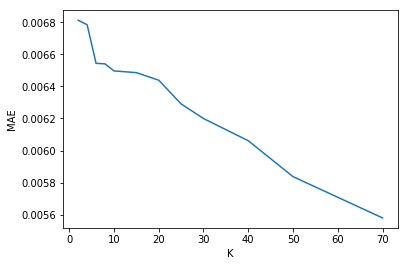

In [13]:
metric = findBestK(bat, U, S, V)

### Based on the graph, it would be optimal to select k = 20

In [14]:
## calculate new reduced components
k = 20
U_red = U[:, :k]
S_red = np.diag(S[:k])
V_red = V[:k, :]
user_red = np.dot(U_red, S_red)
item_red = np.dot(S_red.T, V_red)
# reduced matrix(need for predictions)
R_reduced = np.dot(user_red, item_red)

In [15]:
## calculate User and Item meta-matrices (meta rating by pseudo-users)
S_meta = np.sqrt(S_red)
user = np.dot(U_red, S_meta.T)
item = np.dot(S_meta.T, V_r)
R_meta = np.dot(user, item)

In [16]:
user.shape, item.shape, R_meta.shape

((1000, 20), (20, 4516), (1000, 4516))

In [17]:
# similarity matrix where i, j corresponds to the similarity between item i and j
sim = squareform(pdist(R_meta.T, 'cosine'))

## Find the optimal quantity of neighbors

### Plot the clusters

In [188]:
# finding the clusters in data
scaler =StandardScaler()
pca = PCA(0.95)
X_scaled = scaler.fit_transform(sim)
X_pca = pca.fit_transform(X_scaled)

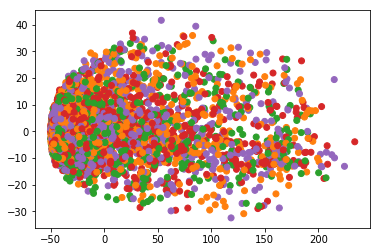

In [183]:
plt.scatter(X_pca[:, 0], X_pca[:,1], c = ['C1', 'C2', 'C3', 'C4'])

In [184]:
kmeans = KMeans(random_state=RANDOM_STATE, n_clusters=10, n_init=100)

In [185]:
kmeans.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=100, n_jobs=1, precompute_distances='auto',
    random_state=17, tol=0.0001, verbose=0)

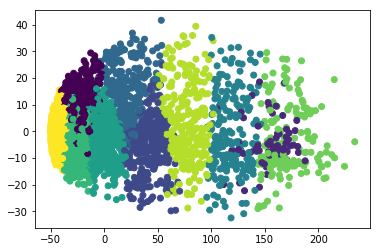

In [187]:
plt.scatter(X_pca[:, 0], X_pca[:,1], c = kmeans.labels_)

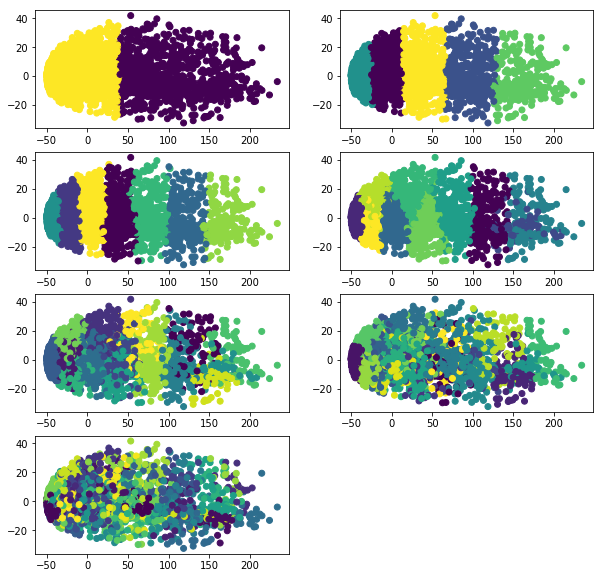

In [192]:
k = [2,5,7,10, 15, 20, 60]
X = np.copy(X_pca)
fig,ax = plt.subplots(figsize=(10,10))
for i,v in enumerate(k):
    kmean = KMeans(random_state=RANDOM_STATE, n_clusters=v, n_init=200)
    kmean.fit(X)
    sub_num = int(str(42)+str(i+1))
    plt.subplot(sub_num)
    plt.scatter(X[:, 0], X[:, 1], c = kmean.labels_)
    plt.title('K = '+str(v))

In [4]:
## k in [7,10] would be a reasonable value

In [18]:
# returns sorted matrix m (items x k) 
# indices of k largest elements in matrix R_reduces (k x items)
def findKNearest(matrix, k=10):
    m = np.copy(matrix)
    k_indices = np.argpartition(m, -k)[-k:]
    m.sort()
    m = m[:, -k:]
    return m, k_indices

In [19]:
k_sim, indices = findKNearest(sim)

## Generate a prediction

In [23]:
# prediction for user 0 and item 1002
kNeigh = 10
i, j = np.where(batch > 0)
true_pred = batch[i[0], j[0]]
pred = np.dot(k_sim[j[0]], (R_reduced[0, k_large_sorted_indices] + mean_rows[0]))/np.sum(np.abs(k_sim[j[0]]))

In [ ]:
# generate P - prediction matrix and compare the MAE
R_disNorm = (R_reduced.T + mean_rows).T

In [163]:
def predict(emb_matrix, k_similarity, inds):
    n,m = emb_matrix.shape[0], emb_matrix.shape[1]
    P = np.zeros((n, m))
    for i in range(n):
        r = emb_matrix[i]
        for j in range(m):
            prediction = np.dot(k_similarity[j],r[inds[:,j]])/np.sum(k_similarity[j])
            P[i,j] = prediction
    return P

In [53]:
# for i in range(n):
#     r = R_disNorm[i]
#     for j in range(m):
#         prediction = np.dot(k_sim[j],r[indices[:,j]])/np.sum(k_sim[j])
#         P[i,j] = prediction

In [170]:
def searchForK(embeddingMat, trueMat, similarityMat):
    """
        embeddingMat  -- reduced matrix, dot product of user&item interation matrix 
                        with k latent factors(R_disNorm)
        trueMat       -- interaction matrix
        similarityMat -- matrix of similarity of items of shape (m x m) with cosine similarity
        
        Returns:
        bestP -- prediction matrix that approximates trueMat best
        **kwargs
    """
    k = np.arange(5, 140, 5)
    A = np.copy(trueMat)
    R = np.copy(embeddingMat)
    score = []
    predictionsMatrix = []
    for i,v in enumerate(k):
        k_similarity, inds = findKNearest(similarityMat, k = v)
        P = predict(embeddingMat, k_similarity, inds)
        bias_correction = np.mean(trueMat) - np.mean(P)   # post processing
        P_corrected = P + bias_correction
        mae = MAE(trueMat, P_corrected)
        score.append(mae)
        print('K: %i; MAE: %.5f'%(v, mae))
#         predictionsMatrix.append(P)
   
    return k, score

In [171]:
%%time
k,mae = searchForK(R_disNorm, batch, sim)

K: 5; MAE: 1.04137
K: 10; MAE: 1.04066
K: 15; MAE: 1.04206
K: 20; MAE: 1.04308
K: 25; MAE: 1.04614
K: 30; MAE: 1.04627
K: 35; MAE: 1.04598
K: 40; MAE: 1.04663
K: 45; MAE: 1.04955
K: 50; MAE: 1.05081
K: 55; MAE: 1.04961
K: 60; MAE: 1.04798
K: 65; MAE: 1.04717
K: 70; MAE: 1.04667
K: 75; MAE: 1.04641
K: 80; MAE: 1.04622
K: 85; MAE: 1.04645
K: 90; MAE: 1.04587
K: 95; MAE: 1.04576
K: 100; MAE: 1.04575
K: 105; MAE: 1.04562
K: 110; MAE: 1.04503
K: 115; MAE: 1.04498
K: 120; MAE: 1.04481
K: 125; MAE: 1.04471
K: 130; MAE: 1.04470
K: 135; MAE: 1.04485
CPU times: user 15min 38s, sys: 16.4 s, total: 15min 54s
Wall time: 16min 12s


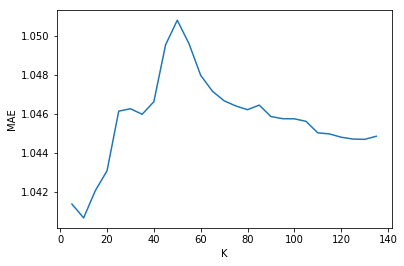

In [173]:
plt.plot(k, mae)
plt.xlabel('K')
plt.ylabel('MAE')

### Assumption has been confirmed, objective mean value with k = 10. It should be not a big one, based on article

In [174]:
kNeigh = 10
k_similarity, inds = findKNearest(sim, k = kNeigh)
P = predict(R_disNorm, k_similarity, inds)
bias_correction = np.mean(batch) - np.mean(P)   # post processing
P_corrected = P + bias_correction  # global bias correction - updating the result on 0.2

## Construct n recommendations for each user

In [175]:
def nLargestRec(A, n=10):
    m = np.copy(A)
    k_indices = np.argpartition(m, -n)[-n:]
    m.sort()
    m = m[:, -n:]
    return m, k_indices


In [186]:
def nLargestRecT(A, n=10):
    m = np.copy(A)
    k_indices = np.argpartition(m.T, -n)[-n:]
    m.sort()
    m = m[:, -n:]
    return m, k_indices

In [176]:
predicted, inds = nLargestRec(P_corrected)  

In [177]:
predicted.shape, inds.shape

((1000, 10), (10, 4516))

### Conclusions
 - Advantages:
    - Solution to the sparsity problem, having the matrix with 80% missing data, we get full filled matrix
    - Opportunity to predict n most likely items for the particular user
 - Disadvantages:
     - No adaptivity. There is no way to predict something for the new user, unless re-train.
     - There is no time factor